#### Code received from [this article](http://nicolovaligi.com/car-speed-estimation-windshield-camera.html)
##### [github](https://gist.github.com/nicolov/d010233ea8d35887c6ab47cca97d396f)
* Parameters changed for my specific application

In [ ]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import clock
from IPython import embed
import pandas as pd

In [ ]:
ls data/

In [ ]:
# Settings for the LK tracker and the corner detector
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 5 )


# image crops

done!
Automatically created module for IPython interactive environment


/Users/jonathanmitchell1/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in true_divide
/Users/jonathanmitchell1/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide
/Users/jonathanmitchell1/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Estimated hf factor = 22671.140477545538
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
          ...   
8586    1.446020
8587    1.319667
8588    1.257698
8589    1.149064
8590    0.965118
8591    0.907445
8592    0.778771
8593    0.700231
8594    0.543131
8595    0.484768
8596    0.384809
8597    0.333291
8598    0.288901
8599    0.200075
8600    0.073404
8601    0.039320
8602    0.029112
8603    0.024446
8604    0.013171
8605   -0.007972
8606   -0.008875
8607   -0.006248
8608   -0.005137
8609   -0.004668
8610   -0.004767
8611   

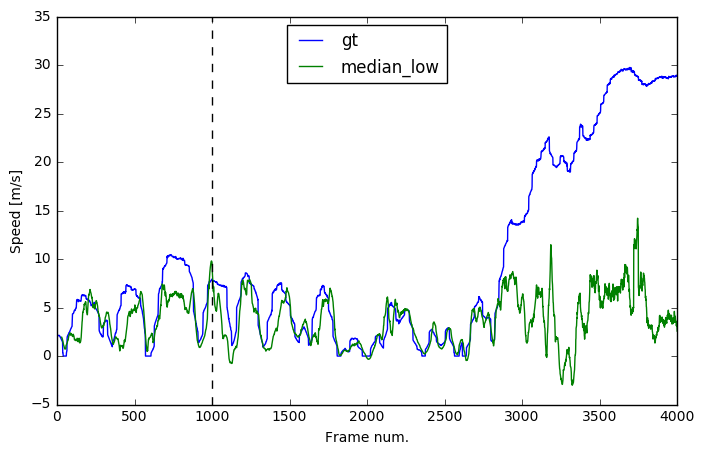

In [26]:
import numpy as np
import cv2
import json
from time import clock
from IPython import embed
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import pandas as pd

# Settings for the LK tracker and the corner detector
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 5 )

# Image crops from left and top edges
crop_left = 0
crop_top = 320


class App:
    def __init__(self, video_src):
        self.track_len = 10
        self.detect_interval = 1
        self.tracks = []
        self.cap = cv2.VideoCapture(video_src)
        self.frame_idx = 0

        # Load ground truth
        gt_raw = np.array(json.load(open('./data/drive.json')))

        # Holds data for each image frame
        self.data_table = pd.DataFrame.from_dict({
            'time': gt_raw[:, 0],
            'gt': gt_raw[:, 1],
            'median': np.nan,
            'mean': np.nan,
            'median_h': np.nan,
            'median_v': np.nan,
            'mean_h': np.nan,
            'mean_v': np.nan})

    def run(self):
        while self.cap.isOpened():
            ret, frame = self.cap.read()
            if not ret:
                break

            frame = frame[320:440:, :-90]

            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            vis = frame.copy()

            # Optical flow tracking

            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                # Compute optical flow
                p0 = self.tracks
                p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
                p0r, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
                # Backtracking check
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                good = d < 1e9

                # Some visualization
                for (x0, y0), (x1, y1), good_flag in zip(p0.reshape(-1, 2), p1.reshape(-1, 2), good):
                    cv2.circle(vis, (x1, y1), 2, (0, 255, 0), -1)
                    pl = np.array([[x0, y0], [x1, y1]], dtype=np.int32)
                    cv2.polylines(vis, [pl], 1, (0, 255, 0))

                # Build an array of (x, y, dx, dy) flows
                flows = np.hstack((p0.reshape(-1, 2), (p1 - p0).reshape(-1, 2)))

                # Switch pixel coordinates to a new frame centered in the middle point
                flows[:, 0] += crop_left - 320
                flows[:, 1] += crop_top - 240

                # Compute the V/hf factor for each flow (2 per flow)
                n_flows = flows.shape[0]

                if n_flows:
                    V_hf = np.zeros(n_flows*2)
                    V_hf[:n_flows] = flows[:, 2] / flows[:, 0] / flows[:, 1]  # H flow
                    V_hf[n_flows:] = flows[:, 3] / (flows[:, 1]**2)  # V flow

                    # Store output
                    self.data_table['median'].iloc[self.frame_idx] = np.median(V_hf)
                    self.data_table['median_h'][self.frame_idx]= np.median(V_hf[:n_flows])
                    self.data_table['median_v'][self.frame_idx]  = np.median(V_hf[n_flows:])

                    self.data_table['mean'][self.frame_idx] = np.mean(V_hf)
                    self.data_table['mean_h'][self.frame_idx] = np.mean(V_hf[:n_flows])
                    self.data_table['mean_v'][self.frame_idx] = np.mean(V_hf[n_flows:])

            #
            # Detection of new points

            # Mask areas close to current points
            mask = np.zeros_like(frame_gray)
            mask[:] = 255
            for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                cv2.circle(mask, (x, y), 5, 0, -1)
            # Mask top center (likely covered by the car ahead)
            cv2.rectangle(mask, (200, 0), (440, 50), 0, -1)
            # Mask edges (outside the road plane)
            cv2.fillPoly(mask,
                         np.array([[(345, 0), (frame_gray.shape[1], 65), (frame_gray.shape[1], 0)]]), 0)
            # cv2.imshow('mask', mask)

            p = cv2.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
            if p is not None:
                self.tracks = p  # p.shape == (n , 1, 2)

            self.frame_idx += 1
            self.prev_gray = frame_gray

            if False:
                cv2.imshow('lk_track', vis)
                ch = 0xFF & cv2.waitKey(1)
                if ch == 27:
                    break

        # Final processing
        self.cap.release()

        # Estimate scale by using the first n frames
        num_training_frames = 1000
                
        # determine hf (height focal length factor) using least squares apprximation 
        # with (coefficient matrix, dependent matrix) as inputs
        
        hf_factor = np.linalg.lstsq(self.data_table['median'][1:num_training_frames].values.reshape(-1, 1),
                                    self.data_table['gt'][1:num_training_frames].values.reshape(-1, 1))
        hf_factor = hf_factor[0][0][0]
        print("Estimated hf factor = {}".format(hf_factor))

        # Use the estimated scale for the rest of the images
        self.data_table[['median', 'median_h', 'median_v', 'mean', 'mean_h', 'mean_v']] *= hf_factor

      
        
        # Some low-passing
        self.data_table['median_low'] = self.data_table['median'].rolling(window=30).mean()

            
     
        # Plot
        ax = self.data_table[['gt', 'median_low']].plot(figsize=(8, 5))
        ax.axvline(x=num_training_frames, color='k', ls='--')
        ax.set_xlim(0, 4000)
        ax.set_xlabel('Frame num.')
        ax.set_ylabel('Speed [m/s]')

        ax.figure.savefig('result.png', bbox_inches='tight')

        plt.show()
print('done!')

def main():
    import sys
    print(__doc__)

    App('./data/drive.mp4').run()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()
  